<a href="https://colab.research.google.com/github/DipeshChothwe/NLP/blob/master/Sentiment_analysis_for_hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
#from google.colab import files

#uploaded = files.upload()

In [195]:
#from google.colab import drive
#drive.mount('/content/drive')

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

# **Understanding our data**

In [197]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [198]:
test_data.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [199]:
train_data.describe().transpose()

,count,unique,top,freq
User_ID,38932,38932,id28938,1
Description,38932,38932,I'm one of those people who have the eyes of a...,1
Browser_Used,38932,11,Firefox,7367
Device_Used,38932,3,Desktop,15026
Is_Response,38932,2,happy,26521


In [200]:
test_data.describe().transpose()

,count,unique,top,freq
User_ID,29404,29404,id103640,1
Description,29404,29404,What a disappointment! Unpleasant desk service...,1
Browser_Used,29404,11,Firefox,5676
Device_Used,29404,3,Desktop,11349


In [201]:
print("length of train data: ", len(train_data))
print("length of test data: ", len(test_data))
print("missing values from train dataset columns:")
print(train_data.isnull().sum())
print("missing values from test dataset columns:")
test_data.isnull().sum()

length of train data:  38932
length of test data:  29404
missing values from train dataset columns:
User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64
missing values from test dataset columns:


User_ID         0
Description     0
Browser_Used    0
Device_Used     0
dtype: int64

In [202]:
print("Unique labels in colummn: Browser_Used",train_data['Browser_Used'].unique())
print("")
print("Number of unique labels in column: Browser_Used", len(train_data['Browser_Used'].unique()))


Unique labels in colummn: Browser_Used ['Edge' 'Internet Explorer' 'Mozilla' 'InternetExplorer' 'Firefox'
 'Google Chrome' 'Chrome' 'IE' 'Opera' 'Mozilla Firefox' 'Safari']

Number of unique labels in column: Browser_Used 11


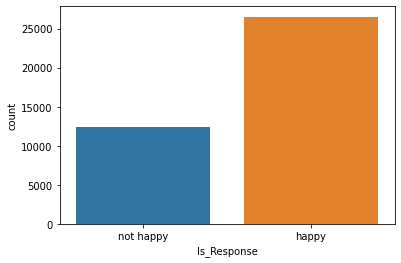

In [203]:
sns.countplot(train_data['Is_Response'])

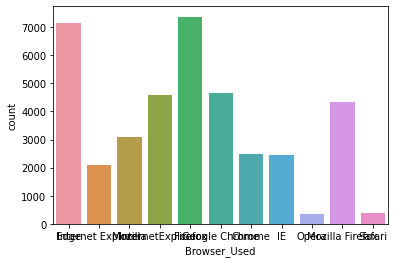

In [204]:
sns.countplot(train_data['Browser_Used'])


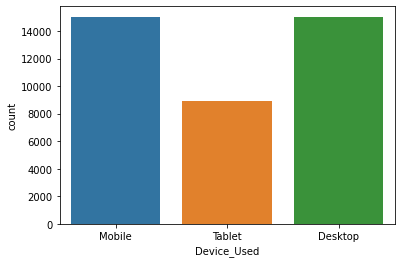

In [205]:
sns.countplot(train_data['Device_Used'])

In [206]:
x = train_data
x = x.groupby('Is_Response')
x.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy
5,id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,happy
6,id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,not happy
7,id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,happy
8,id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,happy
10,id10336,"Steps off Times Square, nice rooms, stayed - n...",Internet Explorer,Tablet,happy




*   Our data does not have null entries
*   Data has more than two times good reviews than bad reviews



# **Data preprocessing**

In [207]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [208]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove tokens that are less than length 2
    text = [t for t in text if len(t) > 1]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
train_data["Description"] = train_data["Description"].apply(lambda x: clean_text(x))


In [209]:
train_data

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,room kind clean strong smell dog generally ave...,Edge,Mobile,not happy
1,id10327,stay crown plaza april april staff friendly at...,Internet Explorer,Mobile,not happy
2,id10328,booked hotel hotwire low price could find got ...,Mozilla,Tablet,not happy
3,id10329,stayed husband son way alaska cruise love hote...,InternetExplorer,Desktop,happy
4,id10330,girlfriend stay celebrate th birthday plan wee...,Edge,Tablet,not happy
...,...,...,...,...,...
38927,id49253,arrive late night walk check-in area completel...,Edge,Desktop,happy
38928,id49254,positive impression location public parking op...,InternetExplorer,Mobile,not happy
38929,id49255,travel friend shop show location great best sa...,Firefox,Mobile,not happy
38930,id49256,experience ok pay extra view pool get view pal...,Chrome,Desktop,not happy


# **Feature engineering**

In [210]:
# add number of characters column
train_data["nb_chars"] = train_data["Description"].apply(lambda x: len(x))

# add number of words column
train_data["nb_words"] = train_data["Description"].apply(lambda x: len(x.split(" ")))

In [211]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()
train_data["sentiments"] = train_data["Description"].apply(lambda x: sid.polarity_scores(x))
train_data = pd.concat([train_data.drop(['sentiments'], axis=1), train_data['sentiments'].apply(pd.Series)], axis=1)

In [212]:
train_data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,nb_chars,nb_words,neg,neu,pos,compound
0,id10326,room kind clean strong smell dog generally ave...,Edge,Mobile,not happy,134,21,0.000,0.457,0.543,0.9501
1,id10327,stay crown plaza april april staff friendly at...,Internet Explorer,Mobile,not happy,621,98,0.021,0.839,0.139,0.8957
2,id10328,booked hotel hotwire low price could find got ...,Mozilla,Tablet,not happy,776,116,0.075,0.760,0.165,0.9118
3,id10329,stayed husband son way alaska cruise love hote...,InternetExplorer,Desktop,happy,320,51,0.020,0.506,0.474,0.9897
4,id10330,girlfriend stay celebrate th birthday plan wee...,Edge,Tablet,not happy,907,134,0.062,0.762,0.176,0.9497


# **Data Visualisation**

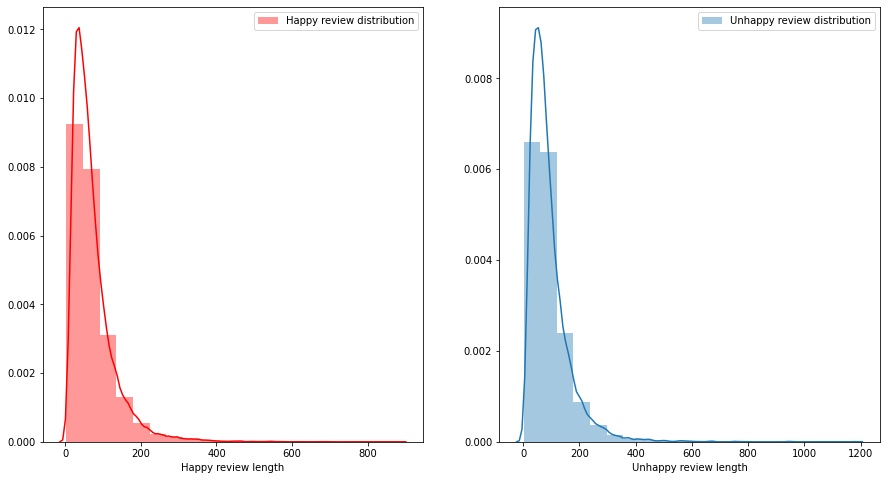

In [213]:

f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(train_data[train_data['Is_Response']=='happy']['nb_words'],bins=20,ax=ax[0],label='Happy review distribution',color='r')

ax[0].set_xlabel('Happy review length')
ax[0].legend()

sns.distplot(train_data[train_data['Is_Response']=='not happy']['nb_words'],bins=20,ax=ax[1],label='Unhappy review distribution')
ax[1].set_xlabel('Unhappy review length')
ax[1].legend()

plt.show()

**Length wise distributionn looks similar for both Happy and Unhappy reviews**

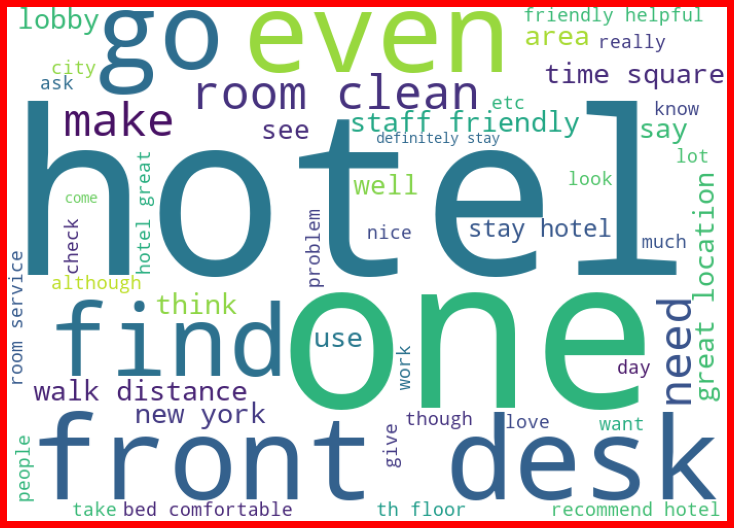

In [214]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


happy = train_data['Description'][train_data['Is_Response']=='happy']

happy_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(happy))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(happy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

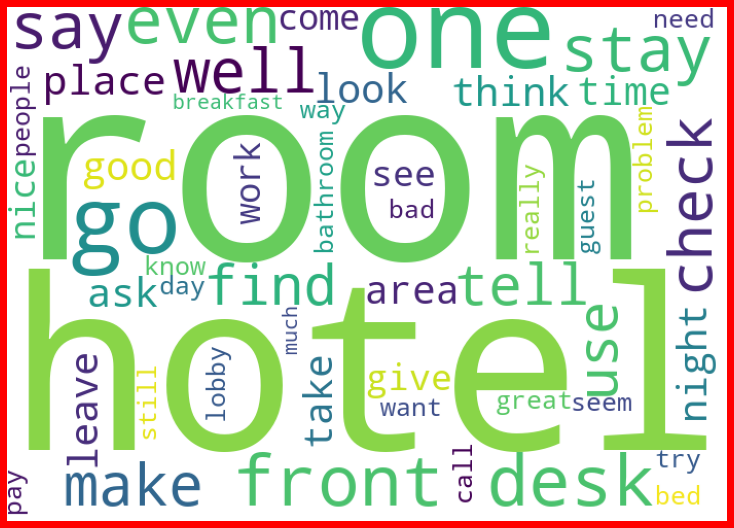

In [215]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


unhappy = train_data['Description'][train_data['Is_Response']=='not happy']

unhappy_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(unhappy))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(unhappy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



**1.   Numbers need to be kept as they inform about specific floors**

**2.   Words that can be added to stopwords:**

*   hotel
*   need
*   use
*   really
*   need
*   see
*   take
*   look
*   through
*   go
*   want
*   still
*   seem
*   try
*   even
*   one
*   etc


---





















# **Model**

In [267]:
train = train_data
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,nb_chars,nb_words,neg,neu,pos,compound,tfd_desc
0,id10326,room kind clean strong smell dog generally ave...,Edge,Mobile,not happy,134,21,0.000,0.457,0.543,0.9501,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
1,id10327,stay crown plaza april april staff friendly at...,Internet Explorer,Mobile,not happy,621,98,0.021,0.839,0.139,0.8957,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
2,id10328,booked hotel hotwire low price could find got ...,Mozilla,Tablet,not happy,776,116,0.075,0.760,0.165,0.9118,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
3,id10329,stayed husband son way alaska cruise love hote...,InternetExplorer,Desktop,happy,320,51,0.020,0.506,0.474,0.9897,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
4,id10330,girlfriend stay celebrate th birthday plan wee...,Edge,Tablet,not happy,907,134,0.062,0.762,0.176,0.9497,"(0, 25019)\t0.20395400677201558\n (0, 16007..."


In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()

naive = MultinomialNB()

feature = tf_vec.fit_transform(train['Description'])

X = feature
y = train['Is_Response']

In [272]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split




In [274]:
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

naive.fit(X_train,Y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8034521730196239


In [275]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       happy       0.78      0.99      0.87      6637
   not happy       0.96      0.40      0.56      3096

    accuracy                           0.80      9733
   macro avg       0.87      0.70      0.72      9733
weighted avg       0.84      0.80      0.77      9733



In [279]:
test_data["Description"] = test_data["Description"].apply(lambda x: clean_text(x))

In [281]:
feature_test = tf_vec.fit_transform(test_data['Description'])

In [282]:
X_testset = feature


In [284]:
y_test= naive.predict(X)
y_test

array(['happy', 'happy', 'happy', ..., 'not happy', 'not happy', 'happy'],
      dtype='<U9')

# **Problem**

In [276]:
# feature selection

ignore_cols = ['Is_Response', 'Browser_Used', 'User_ID','Description','Device_Used']
features = [c for c in train.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[features], y, test_size = 0.20, random_state = 42)

In [277]:
X_train

,nb_chars,nb_words,neg,neu,pos,compound,tfd_desc
5031,317,47,0.000,0.782,0.218,0.9001,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
28166,788,116,0.067,0.683,0.251,0.9817,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
11229,217,35,0.000,0.643,0.357,0.9531,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
7346,267,43,0.081,0.565,0.354,0.9468,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
6316,1368,219,0.087,0.772,0.141,0.9426,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
...,...,...,...,...,...,...,...
6265,225,33,0.062,0.639,0.299,0.8860,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
11284,239,38,0.000,0.705,0.295,0.9153,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
38158,525,81,0.086,0.595,0.319,0.9754,"(0, 25019)\t0.20395400677201558\n (0, 16007..."
860,440,70,0.078,0.603,0.319,0.9657,"(0, 25019)\t0.20395400677201558\n (0, 16007..."


In [278]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

naive.fit(X_train,Y_train)

y_pred= naive.predict(X_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

ValueError: ignored